In [1]:
#Script to plot single bp variations from reference over coverage

In [2]:
#Here we define the folder path that contains the csv files to be parsed
file_path = '/Users/MacProMatt/Desktop/Langlois_Project_005_copy/pile/csv'

In [3]:
import pandas as pd
import os
import csv
from sklearn.preprocessing import RobustScaler
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

In [4]:
#Parse csv files

pos_dict, cov_dict = {}, {}
create_index, index = True, []
for i in os.listdir(file_path):
    if i.endswith('.csv'):
        position = 1
        with open(os.path.join(file_path, i)) as in_file:
            read_file = csv.reader(in_file, delimiter=',', quotechar='|')
            last_chr = ''
            for line in read_file:
                if line[0] in ['M1', 'NA', 'NP', 'NS1', 'PA', 'PB1', 'PB2', 'NEP', 'M2']:
                    chr = line[0]
                    if not last_chr == chr:
                        position = 1
                    last_chr = chr
                    tup = (line[0], position)
                    if tup not in pos_dict:
                        pos_dict[tup] = int(line[4])
                        cov_dict[tup] = int(line[3])
                    if create_index:
                        index.append(tup)
                    else:
                        pos_dict[tup] += int(line[4])
                        cov_dict[tup] += int(line[3])
                position += 1
        create_index = False
        index = pd.MultiIndex.from_tuples(index, names = ['chromosome', 'index'])

In [5]:
#This cell is for filtering out places in the IAV genome where it seems that the flu 
#sequence varies from the reference.
#Set the factor variable to decide how strict of a cutoff this should be.

factor = (33)

for key in pos_dict:
    if pos_dict[key] > cov_dict[key]/(factor):
        print("changed")
        print(key)
        print(pos_dict[key]/cov_dict[key])
        pos_dict[key] = 0

changed
('M1', 6)
0.03409090909090909
changed
('M1', 975)
0.03067484662576687
changed
('M1', 979)
0.08333333333333333
changed
('NP', 5)
0.031578947368421054
changed
('NP', 7)
0.05042016806722689
changed
('NP', 1495)
0.05714285714285714
changed
('NS1', 5)
0.04918032786885246
changed
('PB1', 5)
0.05084745762711865
changed
('PB1', 17)
0.12222222222222222
changed
('PB1', 525)
0.9987046632124352
changed
('PB2', 5)
0.04411764705882353
changed
('PB2', 2182)
0.051934826883910386
changed
('M2', 5)
0.04
changed
('M2', 6)
0.0967741935483871
changed
('M2', 292)
0.06666666666666667


In [6]:
max_error_pos = open('/Users/MacProMatt/Desktop/max_error.txt', 'w')
for key in pos_dict:
    if pos_dict[key] > cov_dict[key]/100:
        max_error_pos.write(str(key)+'\t'+str(pos_dict[key] > cov_dict[key])+'\n')

In [7]:
#create our pandas dataframe
s = pd.Series(pos_dict, name = 'position', index = index)
frame = s.to_frame(name='mutations')
s = pd.Series(cov_dict, name = 'coverage', index = index)
frame['coverage'] = s

In [8]:
#subset dataframe by IAV chromosome

frame.sort_index(level = 0)
frame.index.names = ('chromosome', 'Positon by BP')

m1 = frame.loc["M1"].copy()
m1.name = 'm1'
na = frame.loc["NA"].copy()
na.name = 'na'
np = frame.loc["NP"].copy()
np.name = 'np'
ns1 = frame.loc["NS1"].copy()
ns1.name = 'ns1'
pa = frame.loc["PA"].copy()
pa.name = 'pa'
pb1 = frame.loc["PB1"].copy()
pb1.name = 'pb1'
pb2 = frame.loc["PB2"].copy()
pb2.name = 'pb2'
nep = frame.loc["NEP"].copy()
nep.name = 'nep'
m2 = frame.loc["M2"].copy()
m2.name = 'm2'

df_list = [m1, na, np, ns1, pa, pb1, pb2, nep, m2]

In [9]:
#Normalize the values between 0 and 1 (scale the features to a range)(with account for outliers)

for i in df_list:
    #Data smoothing
    i['norm_cov'] = i['coverage'].rolling(50, min_periods=1, center = True).mean()
    i['norm_mut'] = i['mutations'].rolling(50, min_periods=1, center = True).mean()

    coverage = i['norm_cov'].as_matrix().reshape(-1, 1)
    mutations = i['norm_mut'].as_matrix().reshape(-1, 1)

    transformer_cov = RobustScaler().fit(coverage)
    transformer_mut = RobustScaler().fit(mutations)

    coverage_norm = transformer_cov.transform(coverage)
    mutations_norm = transformer_mut.transform(mutations)

    i['Per Base Coverage'] = coverage_norm
    i['Per Base Mutation Rate'] = mutations_norm
    
    if i.name is 'm1':
        m1_norm = i[['Per Base Mutation Rate', 'Per Base Coverage']].copy()
    elif i.name is 'na':
        na_norm = i[['Per Base Mutation Rate', 'Per Base Coverage']].copy()
    elif i.name is 'np':
        np_norm = i[['Per Base Mutation Rate', 'Per Base Coverage']].copy()
    elif i.name is 'ns1':
        ns1_norm = i[['Per Base Mutation Rate', 'Per Base Coverage']].copy()
    elif i.name is 'pa':
        pa_norm = i[['Per Base Mutation Rate', 'Per Base Coverage']].copy()
    elif i.name is 'pb1':
        pb1_norm = i[['Per Base Mutation Rate', 'Per Base Coverage']].copy()
    elif i.name is 'pb2':
        pb2_norm = i[['Per Base Mutation Rate', 'Per Base Coverage']].copy()
    elif i.name is 'nep':
        nep_norm = i[['Per Base Mutation Rate', 'Per Base Coverage']].copy()
    elif i.name is 'm2':
        m2_norm = i[['Per Base Mutation Rate', 'Per Base Coverage']].copy()
    else:
        print("ERROR: Wrong chromosome names")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


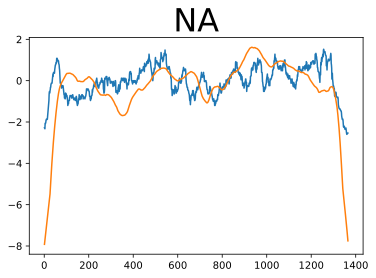

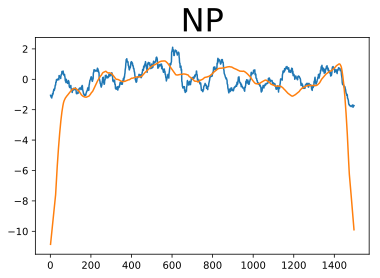

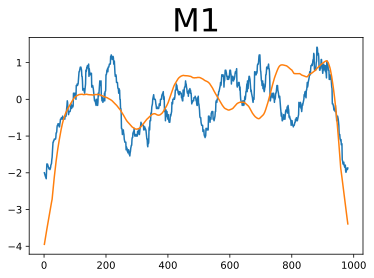

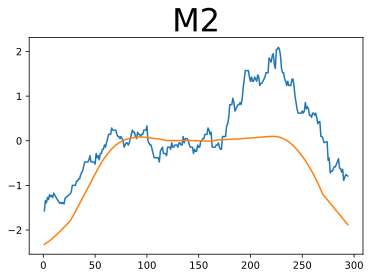

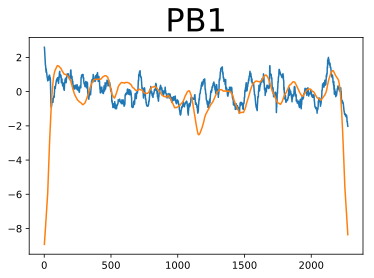

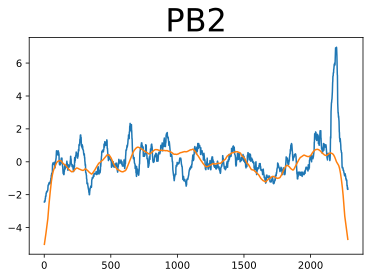

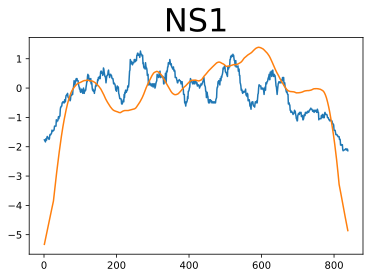

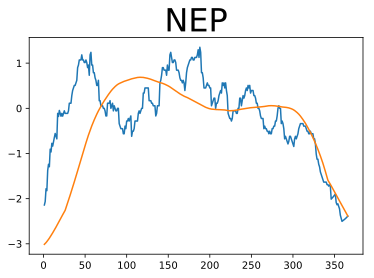

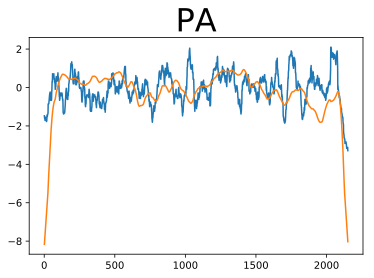

In [10]:
my_plot_na = na_norm.plot.line(title = 'NA', legend = False)
my_plot_na.set_xlabel("")
my_plot_na.title.set_size(32)
#plt.savefig('/Users/MacProMatt/Desktop/chr figure/NA.png', format='png', dpi=1200)

my_plot_np = np_norm.plot.line(title = 'NP', legend = False)
my_plot_np.set_xlabel("")
my_plot_np.title.set_size(32)
#plt.savefig('/Users/MacProMatt/Desktop/chr figure/NP.png', format='png', dpi=1200)

my_plot_m1 = m1_norm.plot.line(title = 'M1', legend = False)
my_plot_m1.set_xlabel("")
my_plot_m1.title.set_size(32)
#plt.savefig('/Users/MacProMatt/Desktop/chr figure/M1.png', format='png', dpi=1200)

my_plot_m2 = m2_norm.plot.line(title = 'M2', legend = False)
my_plot_m2.set_xlabel("")
my_plot_m2.title.set_size(32)
#plt.savefig('/Users/MacProMatt/Desktop/chr figure/M2.png', format='png', dpi=1200)

my_plot_pb1 = pb1_norm.plot.line(title = 'PB1', legend = False)
my_plot_pb1.set_xlabel("")
my_plot_pb1.title.set_size(32)
#plt.savefig('/Users/MacProMatt/Desktop/chr figure/PB1.png', format='png', dpi=1200)

my_plot_pb2 = pb2_norm.plot.line(title = 'PB2', legend = False)
my_plot_pb2.set_xlabel("")
my_plot_pb2.title.set_size(32)
#plt.savefig('/Users/MacProMatt/Desktop/chr figure/PB2.png', format='png', dpi=1200)

my_plot_ns1 = ns1_norm.plot.line(title = 'NS1', legend = False)
my_plot_ns1.set_xlabel("")
my_plot_ns1.title.set_size(32)
#plt.savefig('/Users/MacProMatt/Desktop/chr figure/NS1.png', format='png', dpi=1200)

my_plot_nep = nep_norm.plot.line(title = 'NEP', legend = False)
my_plot_nep.set_xlabel("")
my_plot_nep.title.set_size(32)
#plt.savefig('/Users/MacProMatt/Desktop/chr figure/NEP.png', format='png', dpi=1200)

my_plot_pa = pa_norm.plot.line(title = 'PA', legend = False)
my_plot_pa.set_xlabel("")
my_plot_pa.title.set_size(32)
#plt.savefig('/Users/MacProMatt/Desktop/chr figure/PA.png', format='png', dpi=1200)